# Coin Toss with ADVI Ajax

In [174]:
try:
  from ajax import Prior, Likelihood, Variational, ADVI
except:
  %pip install -qq git+https://github.com/patel-zeel/ajax.git
  from ajax import Prior, Likelihood, Variational, ADVI

try:
  import optax
except:
  %pip install -qq optax
  import optax

try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp

try:
    import seaborn as sns
except:
    %pip install -qq seaborn 
    import seaborn as sns
from ajax.utils import fill_params
import jax
import matplotlib.pyplot as plt
import pickle
tfd = tfp.distributions
tfb = tfp.bijectors

## **Lets' generate some data**

In [209]:
theta_true = 0.8
dist_samples = tfd.Bernoulli(probs=theta_true)
dataset = dist_samples.sample(seed = jax.random.PRNGKey(100),sample_shape = (100,))

## **We will use Beta distribution as a prior for $\theta$**

In [210]:
prior_alpha = 1
prior_beta = 1

prior = Prior(
    distributions = {
        "theta" : tfd.Beta(prior_alpha, prior_beta) #defined prior 
        }
    )

In [211]:
def get_likelihood_params(samples): #this function takes sample from our prior and gives it to likelihood function
  probs = samples["theta"]
  return {"probs" : probs}

likelihood = Likelihood(tfd.Bernoulli, get_likelihood_params) #defined likelihood 

In [212]:
variational = Variational(
    prior=prior,
    bijectors={"theta":tfb.Sigmoid()},  # Since, theta is between 0 and 1 we need to apply sigmoid bijector
    vi_type="full_rank"
)
advi = ADVI(prior, likelihood, variational, dataset)

In [213]:
def train(n_itr,params):
    tx = optax.adam(learning_rate=0.1)
    state = tx.init(params)
    value_and_grad_fun = jax.jit(jax.value_and_grad(advi.loss),static_argnames=['n_samples'])
    seed = jax.random.PRNGKey(100)
    losses = []
    for i in range(n_itr):
        seed = jax.random.split(seed, 1)[0]
        loss, grads = value_and_grad_fun(params, seed = seed,n_samples = 10)
        updates, state = tx.update(grads, state)
        params = optax.apply_updates(params, updates)
        losses.append(loss)
    return params

In [214]:
params = variational.get_params()
params = train(100,params)

In [215]:
# below is the mean, sd of transformed distribution on which sigmoid bijector was applied
mean, sd = jax.tree_leaves(variational.transform_dist(params['theta']))
sd = jnp.sqrt(sd.dot(sd.T))

In [216]:
# here we do the inverse transform of the transformed distribution
def transform(x):
    jacobian = jax.jacobian(jax.scipy.special.logit)
    vmap_jac = jax.vmap(jacobian)
    derivative = abs(jnp.linalg.det(vmap_jac(x)))
    x = x.reshape(x.shape[0],)
    y = derivative * tfd.Normal(loc = mean, scale = sd).prob(jax.scipy.special.logit(x))
    return y

Text(0, 0.5, 'PDF')

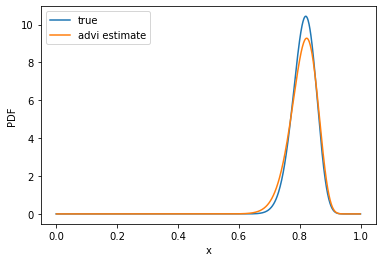

In [220]:
x = jnp.linspace(0,1,1000)
x_new= x.reshape((x.shape[0],1))
y = transform(x_new).flatten()
one= jnp.sum(dataset==1).astype('float32')
zero= jnp.sum(dataset==0).astype('float32')
beta_dist = tfd.Beta(prior_alpha+one, prior_beta+zero)
post_pdf = beta_dist.prob(x)
plt.plot(x,post_pdf,label = "true")
plt.plot(x,y,label = "advi estimate")
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")